In [ ]:
!pip install transformers
!pip install -q mediapy

# Load some samples to check

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1o9lyH8Io0ZvcQ5_4b67ZinYeZ1L1xjv7" -O "/content/test_v2.zip"

In [ ]:
!unzip "test_v2.zip" -d "test_v2"

# Load dependencies

In [4]:
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation, AutoImageProcessor, ViTForImageClassification
import torch
import os
import random
import mediapy as media
import numpy as np

In [5]:
CHECKPOINT_SEGMENTATION = "artemkramov/airbus-ship-challenge-segmentation"
CHECKPOINT_CLASSIFICATION = "artemkramov/airbus-ship-challenge-classifier"
TEST_DIR = "/content/test_v2"

# Create a class to perform segmentation

In [6]:
class AirbusSemanticSegmentation():
  """
  Class to perform the semantic segmentation on the airbus challenge dataset
  """

  def __init__(self, checkpoint_segmentation, checkpoint_classification) -> None:
      """
      Constructor to initialize all models
      :param str checkpoint_segmentation: path to the semantic segmentation model
      :param str checkpoint_classification: path to the classification model
      """

      # Set device (GPU)
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # Define the preprocessor in order to transform input images to desired input of the MaskFormer model
      self.preprocessor = MaskFormerImageProcessor(ignore_index=-1, reduce_labels=False, do_resize=False,
                                                    do_rescale=False, do_normalize=False)

      # Load the pre-trained semantic segmentation model
      self.model = MaskFormerForInstanceSegmentation.from_pretrained(checkpoint_segmentation)
      self.model = self.model.to(self.device)
      self.model = self.model.eval()

      # Load the pre-trained classification model
      # Load both a preprocessor and the pre-trained model
      self.image_processor_classifier = AutoImageProcessor.from_pretrained(checkpoint_classification)
      self.model_classifier = ViTForImageClassification.from_pretrained(checkpoint_classification)
      self.model_classifier = self.model_classifier.to(self.device)
      self.model_classifier = self.model_classifier.eval()

  def prepare_batch(self, image):
      """
      Convert an input image to the dictionary of MaskFormer-related fields
      :param np.ndarray image: input image
      :return: batch with pixel values and masks
      :rtype: dict
      """
      return self.preprocessor(
          [image],
          return_tensors="pt",
      )

  def prepare_batch_classifier(self, image):
    """
    Convert an input image to the dictionary of ViT-related fields
    :param np.ndarray image: input image
    :return: batch with pixel values
    :rtype: dict
    """
    return self.image_processor_classifier(
      [image],
      return_tensors="pt",
    )

  def get_label(self, image):
    """
    Get label for the image
    :param np.ndarray image: input image
    :return: integer label where 1 indicates that the image contains a ship
      0 means that there is no ship there
    :rtype: int
    """

    # Prepare batch
    batch = self.prepare_batch_classifier(image)

    # Get logits
    with torch.no_grad():
      logits = self.model_classifier(pixel_values=batch['pixel_values'].to(self.device)).logits

    # Model predicts one of the 2 classes: without ship and with ship
    predicted_labels = torch.argmax(logits, dim=1).cpu().detach().numpy()

    return predicted_labels[0]

  def get_segmentation_map(self, image, use_classifier=True):
      """
      Given an input image, the function returns a predicted segmentation map (binary mask)
      :param np.ndarray image: input image of a shape (768, 768, 3)
      :param bool use_classifier: whether to use a classifier in order to decide whether to apply
        the segmentation model or not
      :return: binary mask with a shape (768, 768) where 1 defines a ship, 0 is a background
      :rtype: np.ndarray
      """

      # If we are using the classifier than we check if the image should be
      # segmented at all
      if use_classifier and (not self.get_label(image)):
        mask = np.zeros(image.shape)
        return mask

      # Prepare the batch
      batch = self.prepare_batch(image)

      # Predict output data
      with torch.no_grad():
          outputs = self.model(pixel_values=batch["pixel_values"].to(torch.float).to(self.device))

      # Get expected shapes of binary masks
      target_sizes = [(image.shape[1], image.shape[2]) for image in batch["pixel_values"]]

      # Predict segmentation maps
      predicted_segmentation_maps = self.preprocessor.post_process_semantic_segmentation(outputs,
                                                                                          target_sizes=target_sizes)

      # Transform mask to numpy
      mask = predicted_segmentation_maps[0].cpu().detach().numpy().astype("uint")

      # Clear memory
      del outputs
      del predicted_segmentation_maps
      torch.cuda.empty_cache()

      return mask


In [7]:
segmentation_model = AirbusSemanticSegmentation(checkpoint_segmentation=CHECKPOINT_SEGMENTATION,
                                                checkpoint_classification=CHECKPOINT_CLASSIFICATION)

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:429: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
def show_image_and_mask(image, mask):
  """
  Resize and show both an image and a mask
  :param np.ndarray image: input image
  :param np.ndarray mask: binary mask
  :return: None
  """
  resize_shape = (400, 400)
  image = media.resize_image(image, resize_shape)
  mask = media.resize_image(mask, resize_shape)
  media.show_images([image, mask])

def show_random_sample(use_classsifier=True):
  """
  Get a random image from the test directory, predict a mask, and visualize them
  :param bool use_classsifier: whether to use a classifier or not
  :return: None
  """

  # Get a random file in the test directory
  filenames = os.listdir(TEST_DIR)
  filename = random.choice(filenames)
  filepath = os.path.join(TEST_DIR, filename)

  # Read image, predict a mask, and display them
  image = media.read_image(filepath)
  mask = segmentation_model.get_segmentation_map(image, use_classsifier)
  show_image_and_mask(image, mask)



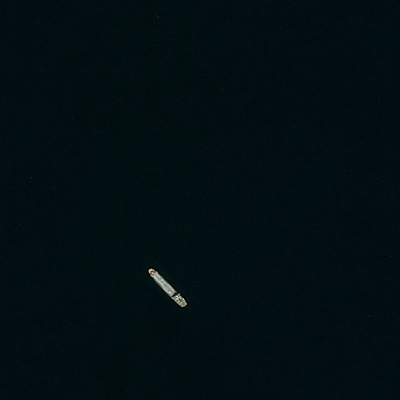
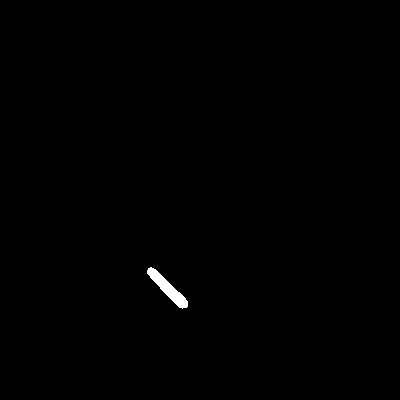


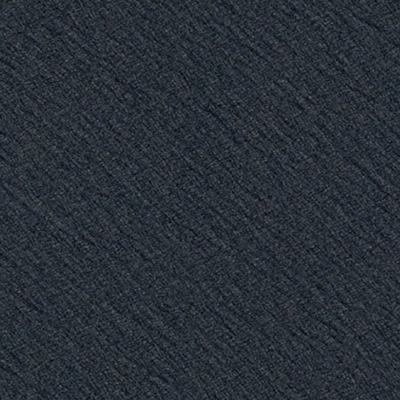
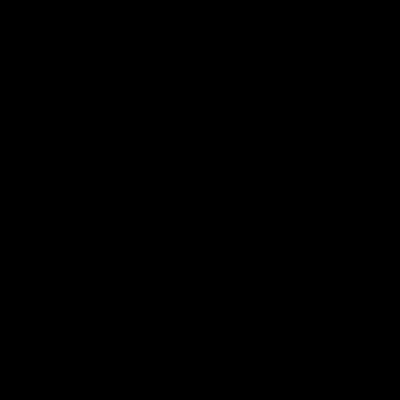


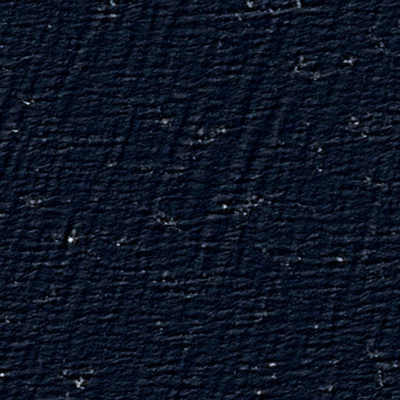
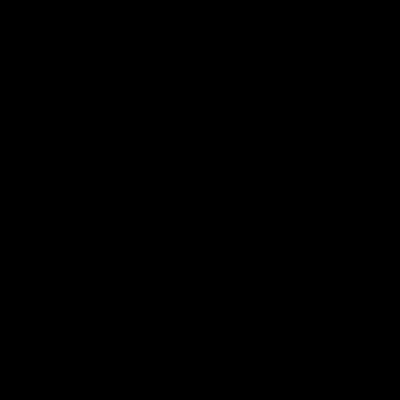


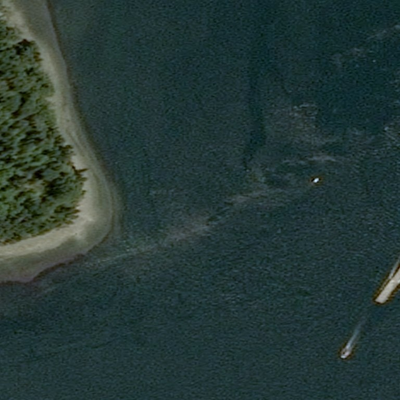
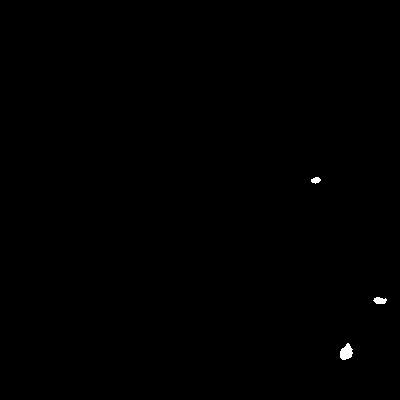


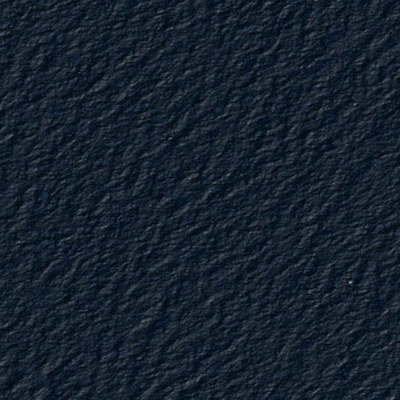
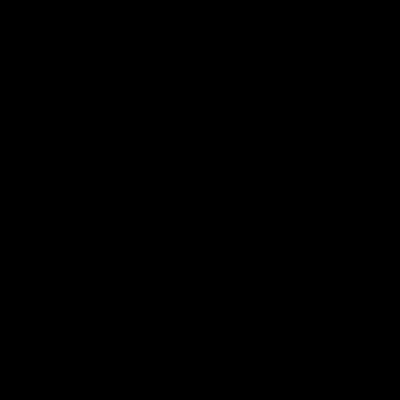


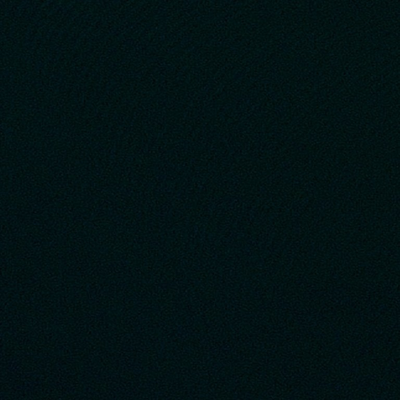
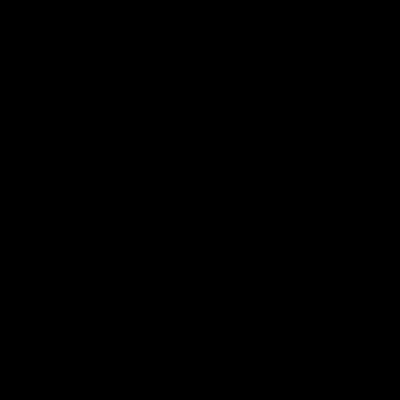


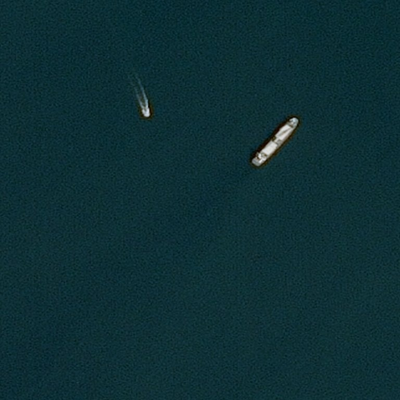
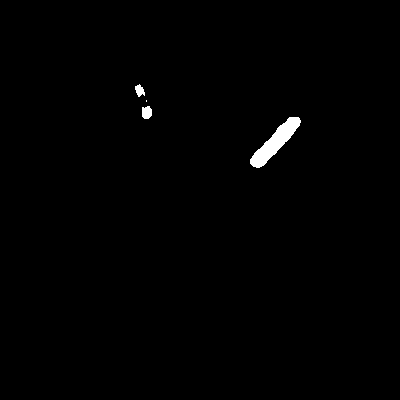


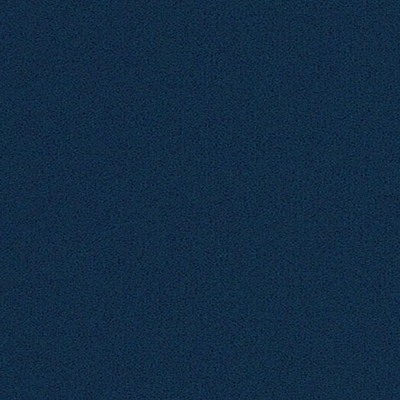
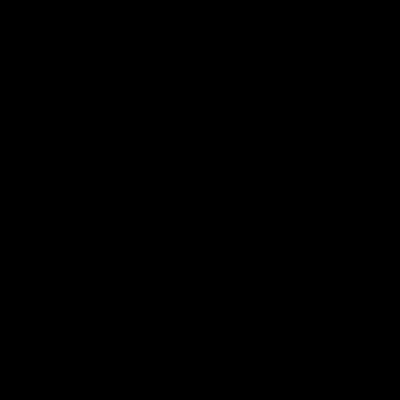


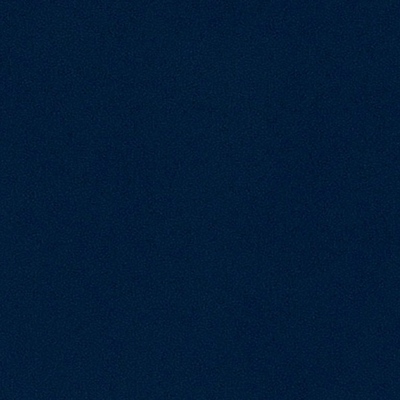
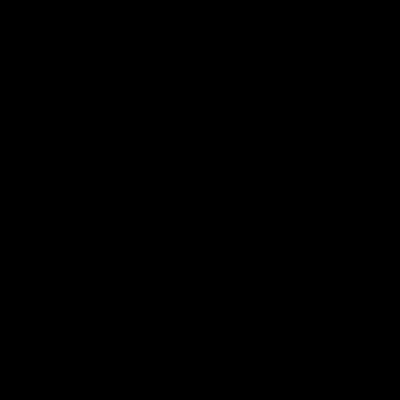


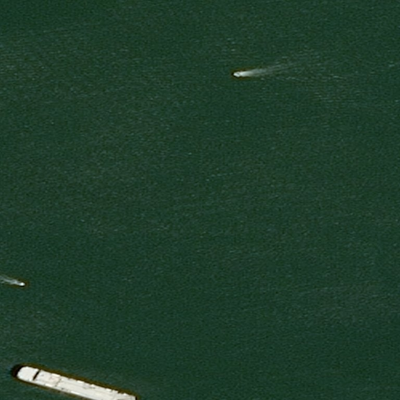
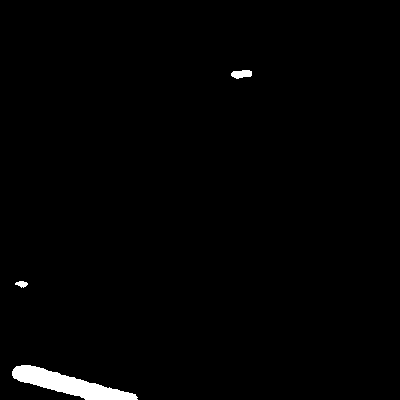


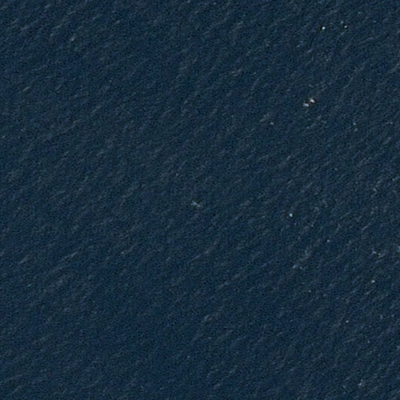
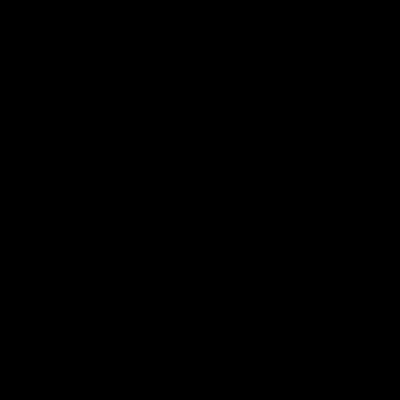


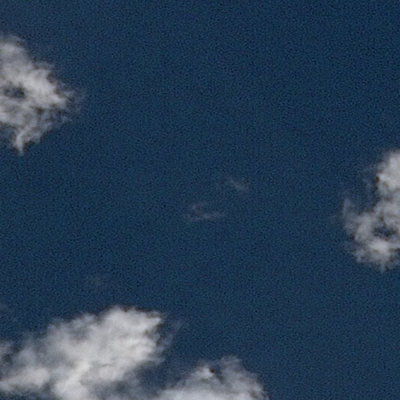
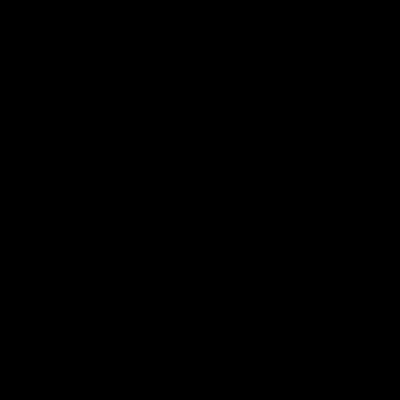


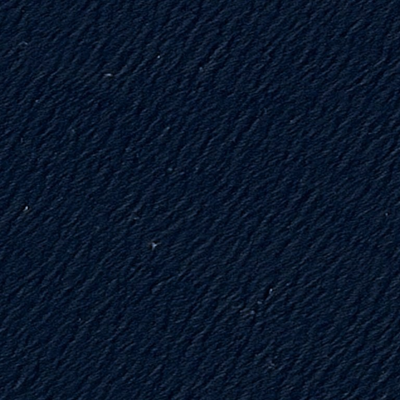
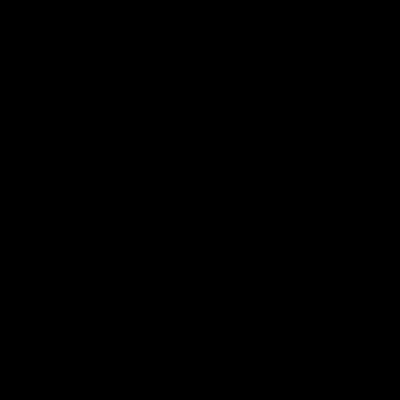


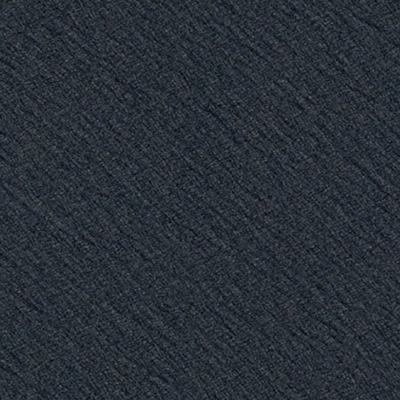
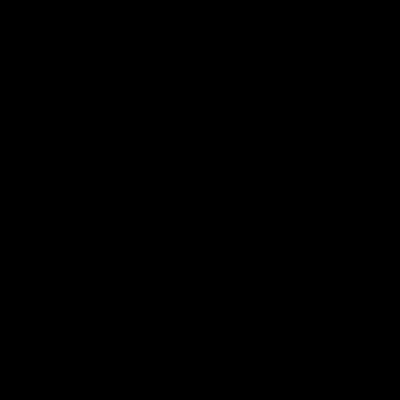


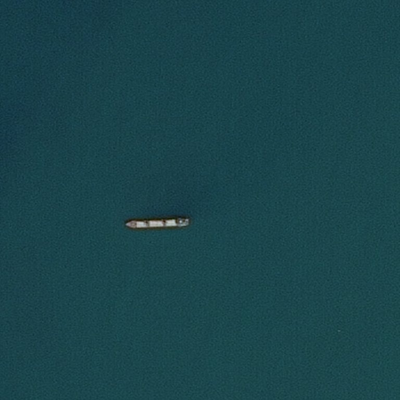
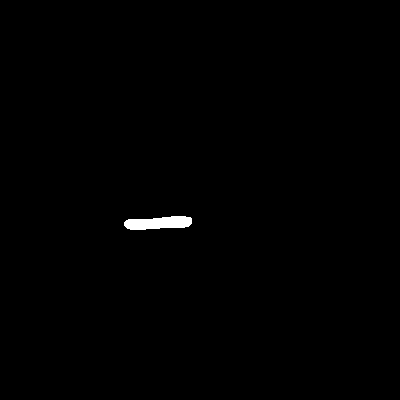


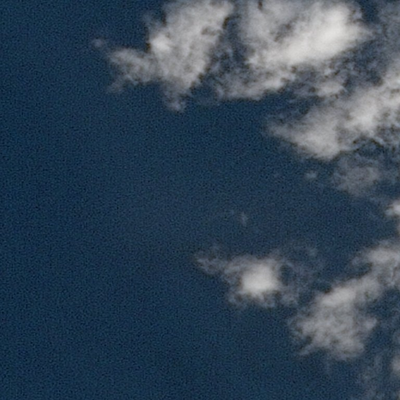
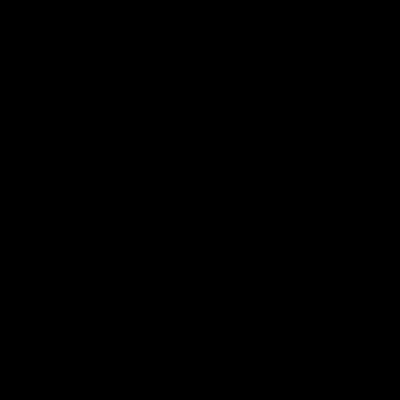

In [9]:
for i in range(0, 16):
  show_random_sample()